# Torch

Heavily based on the [TorchVision Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [1]:
%%bash

pip install cython

# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-mputhzbu
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-mputhzbu


## Step 1. Download and define the dataset

Download the [MineApple fruit detection dataset](https://rsn.umn.edu/projects/orchard-monitoring/minneapple). This should take ~30 seconds.

In [2]:
%%bash

wget --no-clobber https://conservancy.umn.edu/bitstream/handle/11299/206575/detection.tar.gz -O data/detection.tar.gz
tar -xvf data/detection.tar.gz --directory data/

detection/test/images/dataset2_back_630.png
detection/train/masks/20150919_174151_image11.png
detection/train/images/20150919_174730_image161.png
detection/train/masks/20150921_131346_image1121.png
detection/train/masks/20150921_131234_image546.png
detection/test/images/dataset3_front_510.png
detection/train/images/20150921_131346_image1121.png
detection/train/images/
detection/train/masks/20150921_132245_image396.png
detection/train/masks/20150921_131453_image676.png
detection/train/masks/20150921_131833_image296.png
detection/train/images/20150919_174151_image301.png
detection/train/images/20150921_132038_image76.png
detection/train/masks/20150921_131453_image1196.png
detection/train/images/20150921_131346_image51.png
detection/train/masks/20150921_132038_image1241.png
detection/test/images/dataset4_front_900.png
detection/test/images/dataset4_front_1020.png
detection/train/images/20150919_174730_image216.png
detection/train/images/20150921_131453_image1196.png
detection/train/images

File ‘data/detection.tar.gz’ already there; not retrieving.


In [3]:
from pathlib import Path

import numpy as np
import torch
import torch.utils.data
from PIL import Image


class MinneAppleDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = Path(root)
        self.transforms = transforms

        self.image_dir = root / "images"
        self.mask_dir = root / "masks"
        self.image_paths = list(sorted(self.image_dir.glob("*.png")))
        self.mask_paths = [self.mask_dir / x.name for x in self.image_paths]
        assert all(x.exists() for x in self.mask_paths), "Missing mask files."

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        image = Image.open(image_path).convert("RGB")
        mask = np.array(Image.open(mask_path))

        object_ids = np.unique(mask)
        object_ids = object_ids[1:]
        masks = mask == object_ids[:, None, None]

        boxes = []
        for object_mask in masks:
            pixel_indices = np.where(object_mask)
            xmin = np.min(pixel_indices[1])
            xmax = np.max(pixel_indices[1])
            ymin = np.min(pixel_indices[0])
            ymax = np.max(pixel_indices[0])
            # TODO: Why are there bad bboxes?
            if xmin == xmax or ymin == ymax:
                continue
            boxes.append([xmin, ymin, xmax, ymax])

        num_objects = len(object_ids)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objects,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objects,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.image_paths)

In [160]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

def draw_seg(img, target):
    img = (img * 255).to(torch.uint8)
    masks = target["masks"].squeeze(1).to(bool)
    boxes = target["boxes"]
    result = img
    result = draw_segmentation_masks(result, masks, colors=["white"]*len(masks), alpha=0.3)
    result = draw_bounding_boxes(result, boxes, colors=["white"]*len(masks))
    return result

def show(img):
    plt.figure(figsize=(12, 12))
    plt.imshow(to_pil_image(img))

In [146]:
root = Path("data/detection/")
train_root = root / "train"

In [147]:
dataset = MinneAppleDataset(train_root, get_transform(train=True))

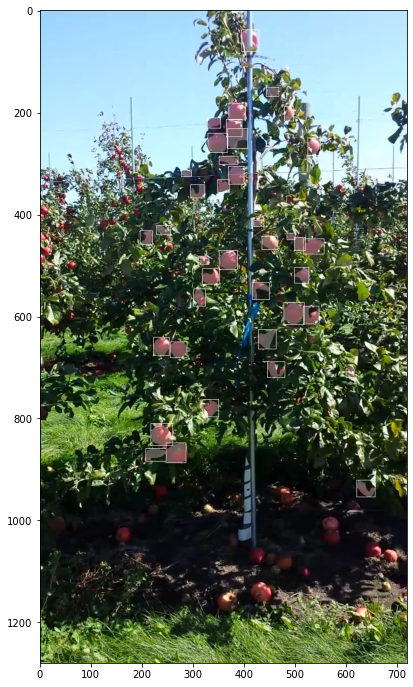

In [161]:
sample_idx = torch.randint(len(dataset), size=(1,)).item()
img, target = dataset[sample_idx]
show(draw_seg(*dataset[sample_idx]))

## Step 2. Train a fine-tuned model

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

In [5]:
%%bash

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [6]:
from engine import train_one_epoch, evaluate
import transforms as T
import utils


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
dataset = MinneAppleDataset(train_root, get_transform(train=True))
dataset_test = MinneAppleDataset(train_root, get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 1

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/310]  eta: 0:24:25  lr: 0.000021  loss: 4.3994 (4.3994)  loss_classifier: 0.6844 (0.6844)  loss_box_reg: 0.8390 (0.8390)  loss_mask: 1.9854 (1.9854)  loss_objectness: 0.6864 (0.6864)  loss_rpn_box_reg: 0.2042 (0.2042)  time: 4.7289  data: 0.8716  max mem: 2600
Epoch: [0]  [ 10/310]  eta: 0:05:49  lr: 0.000183  loss: 3.4682 (3.6649)  loss_classifier: 0.6844 (0.6496)  loss_box_reg: 0.8128 (0.7444)  loss_mask: 1.0892 (1.4075)  loss_objectness: 0.5323 (0.6886)  loss_rpn_box_reg: 0.2000 (0.1748)  time: 1.1653  data: 0.0959  max mem: 3358
Epoch: [0]  [ 20/310]  eta: 0:04:47  lr: 0.000344  loss: 2.4406 (2.9060)  loss_classifier: 0.4998 (0.5433)  loss_box_reg: 0.5876 (0.6388)  loss_mask: 0.8816 (1.0525)  loss_objectness: 0.3338 (0.5196)  loss_rpn_box_reg: 0.1371 (0.1519)  time: 0.8035  data: 0.0178  max mem: 3358
Epoch: [0]  [ 30/310]  eta: 0:04:18  lr: 0.000506  loss: 1.7333 (2.4731)  loss_classifier: 0.3499 (0.4719)  loss_box_reg: 0.5065 (0.5988)  loss_mask: 0.4862 (0.8506) 

Save the model for inference.

In [18]:
outputs_dir = Path("outputs")
outputs_dir.mkdir(exist_ok=True)
model_path = outputs_dir / "torch_model.pt"
torch.save(model.state_dict(), model_path)

## Step 3. Inference

Load the model for inference.

In [28]:
inference_model = get_instance_segmentation_model(num_classes)
inference_model.load_state_dict(torch.load(model_path))
inference_model.to(device)
inference_model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [164]:
img, target = dataset_test[0]
with torch.no_grad():
    [prediction] = inference_model([img.to(device)])

In [159]:
from torchvision.utils import make_grid

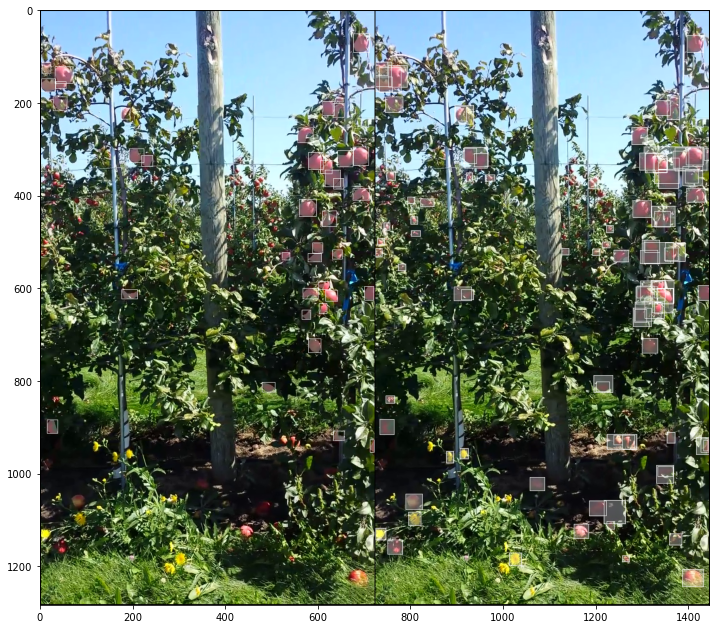

In [166]:
grid = make_grid(
    [
        draw_seg(img, target),
        draw_seg(img, prediction)
    ]
)
show(grid)